# Problem Statement

The problem is to classify images of objects to ten categories which will be shown below. The dataset here is a slighted changed version of a famous dataset used for computer-vision. In this project, I build and evaluate a CNN model, also try some things to decrease overfitting. Then, I fine-tune a pre-trained CNN model. Lastly, I additionlly use a transformer model which is built for computer vision.  

# Dataset

Here I have a dataset called "imagenettetvt320", a slightly modified version of the imagenette dataset from fastai.

The dataset can be found here: https://www.kaggle.com/datasets/valdivinosantiago/imagenettetvt320

(Imagenette itself is a dataset derived from a larger ImageNet dataset which is a large-scale visual recognition challenge. Imagenette is a smaller subset of it, and includes 10 easily classifiable classes that are a representative sample of the larger dataset.)

----------------------------------------------------------------------------------------------------------------------------------------------

The difference between "imagenettetvt320" and "Imagenette" is: the original validation dataset now is splitted into two -- validation dataset with 1/3 of the images of the original validation set, and 2/3 of the images compose the test dataset. 

1) Totally 10 classes: cassetePlayer, ChainShaw, Church, EnglishSpringer, FrenchHorn, GarbageTruck, GasPump, GolfBall, parachute, tench.

2) 9469 images(70.7%) in the training, 1309 images(9.78%) in the validation, 2616 images(19.53%) in the test.


I can find more below about the data.

# Steps


1. Data Exploration

2. Initial CNN model   --- inspired by: https://github.com/RanFeldesh/deep-learning-tutorials

3. Works to prevent overfitting  --- inspired by the above notebook and tensorflow official website, stackoverflow as well as chatgpt

4. Fine-tuning a traditional CNN model --- reference: https://github.com/RanFeldesh/deep-learning-tutorials

5. Fine-tuning Vision Transformer(ViT) --- reference: chatgpt, official website, https://www.kaggle.com/code/raufmomin/vision-transformer-vit-fine-tuning/notebook#Overview

6. Summary

## 1. Data Exploration

In this step, I ①retrieve data from the path; ②specify the size and batch; ③settle down three datasets: train,validation, test.

In [77]:
np.random.seed(42)
tf.random.set_seed(42)

#### dataset collection

In [2]:
train_dataset_path = '/kaggle/input/imagenettetvt320/train'
validation_dataset_path = '/kaggle/input/imagenettetvt320/val'
test_dataset_path ='/kaggle/input/imagenettetvt320/test' 

#### data preview

In [2]:
import tensorflow as tf

tf.random.set_seed(42)
train_data= tf.keras.preprocessing.image_dataset_from_directory(directory=train_dataset_path,
                                                                            image_size=(224,224),
                                                                           label_mode="categorical",
                                                                            batch_size=32)
valid_data = tf.keras.preprocessing.image_dataset_from_directory(directory=validation_dataset_path,
                                                                            image_size=(224,224),
                                                                          label_mode="categorical",
                                                                            batch_size=32)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dataset_path,
                                                                            image_size=(224,224),
                                                                          label_mode="categorical",
                                                                            batch_size=32)

Found 9469 files belonging to 10 classes.
Found 1309 files belonging to 10 classes.
Found 2616 files belonging to 10 classes.


In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
import os
train = sorted(os.listdir(train_dataset_path))
valid = sorted(os.listdir(validation_dataset_path))
test = sorted(os.listdir(test_dataset_path))


f"training classes : {train}"
f"validation classes: {valid}"
f"testing classes : {test}"

"testing classes : ['cassetePlayer', 'chainShaw', 'church', 'englishSpringer', 'frenchHorn', 'garbageTruck', 'gasPump', 'golfBall', 'parachute', 'tench']"

In [4]:
# one way to validate the above findings and settings
for data_batch, labels_batch in train_data:
    print("data batch shape:", data_batch.shape)              
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 224, 224, 3)
labels batch shape: (32, 10)


<AxesSubplot:>

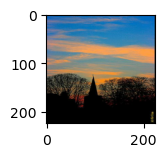

In [8]:
#validate what data_batch is 

from matplotlib import pyplot as plt
import numpy as np
plt.subplot(3, 3, 3)
pyplot.imshow(np.array(data_batch[7],dtype=np.uint8))

Now, I are sure that:

I have train/valid/test, each with 10 labels. 

Each images has size of 224,224,3. 

When do the training, I make the batch size 32.

#### access and visualize the data


This part is inspired by: https://www.kaggle.com/code/adityavipradas/ensemble-93-acc-resnet50-inceptionv3-effnetb7/notebook

In [9]:
# a closer look on the data
for tr in train:
    tr_path = os.path.join(train_dataset_path, tr)
    filename1=os.listdir(tr_path)
    print(f"for training, the number of samples in {tr} under train is {len(filename1)}")

for va in valid:
    va_path = os.path.join(validation_dataset_path, va)
    filename2=os.listdir(va_path)
    print(f"for validation, the number of samples in {va} under valid is {len(filename2)}")

for te in test:
    te_path = os.path.join(test_dataset_path, te)
    filename3=os.listdir(te_path)
    print(f"for testing, the number of samples in {te} under test is {len(filename3)}")

for training, the number of samples in cassetePlayer under train is 993
for training, the number of samples in chainShaw under train is 858
for training, the number of samples in church under train is 941
for training, the number of samples in englishSpringer under train is 955
for training, the number of samples in frenchHorn under train is 956
for training, the number of samples in garbageTruck under train is 961
for training, the number of samples in gasPump under train is 931
for training, the number of samples in golfBall under train is 951
for training, the number of samples in parachute under train is 960
for training, the number of samples in tench under train is 963
for validation, the number of samples in cassetePlayer under valid is 119
for validation, the number of samples in chainSaw under valid is 129
for validation, the number of samples in church under valid is 136
for validation, the number of samples in englishSpringer under valid is 132
for validation, the number of 

I can see that, roughly speaking, 

in train dataset, under each label there're like 800/900 images; 

in validation, it is like 100/200 images;

in test, it's like 200/300 images. 

In summary, the ratio is almost---Train : Valid : Test = 0.7 : 0.1 : 0.2 ≈ 0.8 : 0.2. Fine distribution.

Text(0.5, 0.98, 'cassetePlayer')

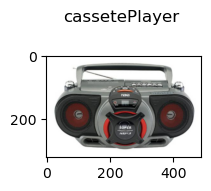

Text(0.5, 0.98, 'chainShaw')

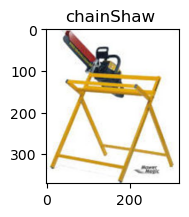

Text(0.5, 0.98, 'church')

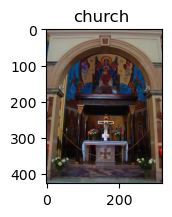

Text(0.5, 0.98, 'englishSpringer')

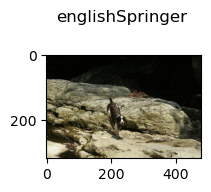

Text(0.5, 0.98, 'frenchHorn')

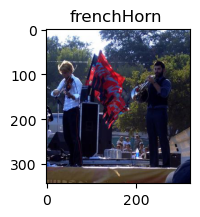

Text(0.5, 0.98, 'garbageTruck')

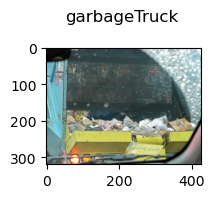

Text(0.5, 0.98, 'gasPump')

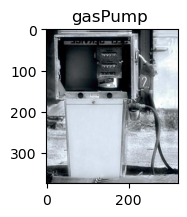

Text(0.5, 0.98, 'golfBall')

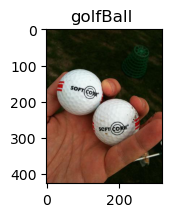

Text(0.5, 0.98, 'parachute')

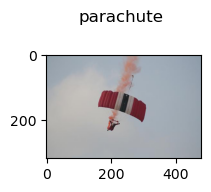

Text(0.5, 0.98, 'tench')

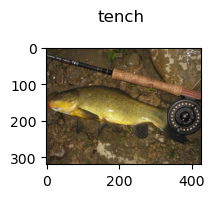

In [10]:
#what the images look like
from matplotlib.image import imread
import matplotlib.pyplot as plt

for tr in train:
    tr_path = os.path.join(train_dataset_path, tr)
    filename1=os.listdir(tr_path)   
    fig = plt.figure(figsize=(2, 2))
    filepath = os.path.join(train_dataset_path, tr,filename1[0])
    image = imread(filepath)
    plt.imshow(image)
    plt.suptitle(tr)
    plt.show()

Now I understand what the data is. 

## 2. Initial CNN

I build a rough CNN first.

#### model building

I simply conv, pool, flatten, fully conntect layers. Here I don't input data or compile, I just want to see the architecture.

I specify the model's and each layer's name so that it could be more clear.

In [117]:
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.layers import Conv2D, MaxPooling2D
inputs = keras.Input(shape=(224, 224, 3),name='IN')
x = layers.Rescaling(1./255)(inputs)  
x = layers.Conv2D(filters=30,kernel_size=3,strides=(3,3),activation="relu",name='CONV1')(x)                 
x = layers.MaxPooling2D(pool_size=2,name='POOL1')(x)
x = layers.Conv2D(filters=60,kernel_size=3,strides=(3,3),activation="relu",name='CONV2')(x)
x = layers.MaxPooling2D(pool_size=2,name='POOL2')(x)
x = layers.Flatten(name='FLATTEN')(x)
outputs = layers.Dense(80, activation="relu")(x)
outputs = layers.Dense(50, activation="relu")(x)
outputs = layers.Dense(10, activation="softmax",name='OUT')(x)
m1 = keras.Model(inputs=inputs, outputs=outputs,name='M1')
m1.summary()

Model: "M1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 IN (InputLayer)             [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_24 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 CONV1 (Conv2D)              (None, 74, 74, 30)        840       
                                                                 
 POOL1 (MaxPooling2D)        (None, 37, 37, 30)        0         
                                                                 
 CONV2 (Conv2D)              (None, 12, 12, 60)        16260     
                                                                 
 POOL2 (MaxPooling2D)        (None, 6, 6, 60)          0         
                                                                 
 FLATTEN (Flatten)           (None, 2160)              0        

#### calculation for each layer of the model

input: 224,224,3

conv: (w-k+2p)/s+1=(224-3+2*0)/3+1=74,74,30

pool: (74-2)/2+1=37,37,30

conv: (37-3+2x0)/3+1=12,12,60

pool: (12-2)/2+1=6,6,60

flatten: 6x6x60=2160

fully connected layer: 10

#### plotted summary of model

more visualized

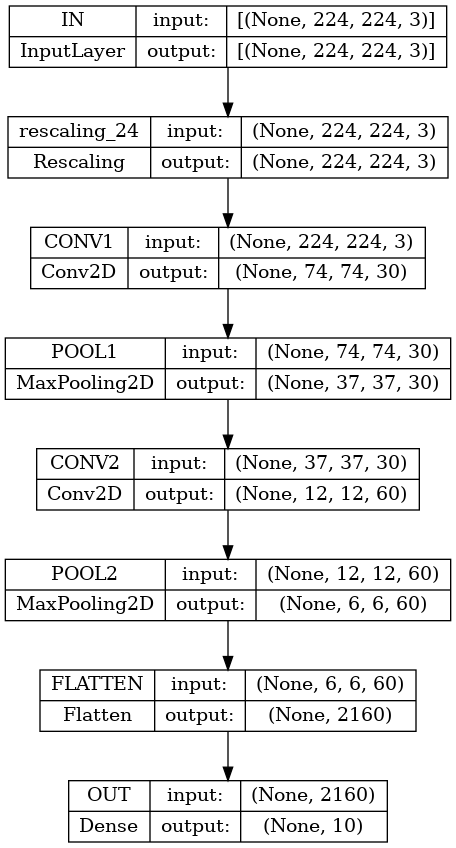

In [118]:
from tensorflow.keras.utils import plot_model
plot_model(m1, to_file='model_class1.png', show_shapes=True)

#### model compile and fit

Now I compile with loss, optimizer and accuracy, finally plug in data.

In [119]:
m1.compile(loss="categorical_crossentropy", 
                optimizer="Adam",
                metrics=["accuracy"])

history=m1.fit(train_data,epochs=30,verbose=0,validation_data=valid_data)

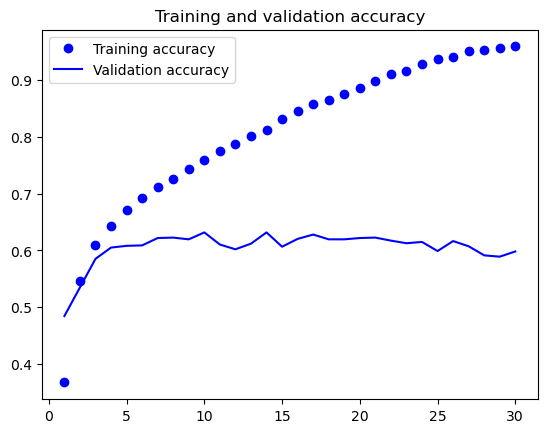

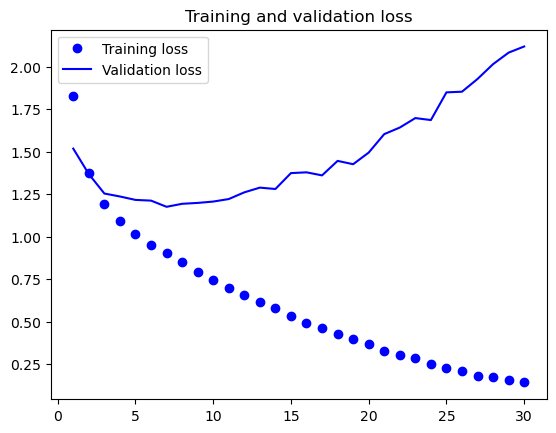

In [120]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Might be overfitting.

Valid: accuracy stops improving at a certain period, and loss stops decreasing at a certain period--it is actually increasing most of times. 

And whether it is accuracy or loss, in terms of the numbers(figures), they always behave worse than train data--the accuracy line is under train's, and the loss line is above train's.

#### prediction

In [124]:
test1_loss, test1_acc=m1.evaluate(test_data)
print(f"initial accuracy: {test1_acc:.5f}")                                     

82/82 [==============================] - 4s 43ms/step - loss: 2.1850 - accuracy: 0.6193
initial accuracy: 0.61927


And the accuracy of prediction is not good neither. 

## 3. Works to prevent overfitting

#### ①augmentation

I "zoom in" the data, like exposing data to a wider range of variations, such as changing orientation, flipping, rescale, lighting... This artificially increases the size of the training dataset, and helps generalize better to unseen data.

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.4),
        layers.RandomBrightness(factor=0.2)

    ]
)

***take a look at what it will bring***

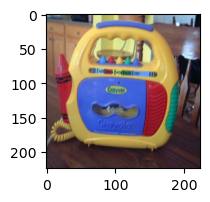

In [170]:
fig = plt.figure(figsize=(2, 2))
plt.imshow(np.array(data_batch[20],dtype=np.uint8))

***randomly generate once*** 

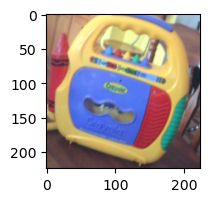

In [182]:
fig = plt.figure(figsize=(2, 2))
plt.imshow(np.array(data_augmentation(data_batch[20]),dtype=np.uint8))

***randomly generate six times***

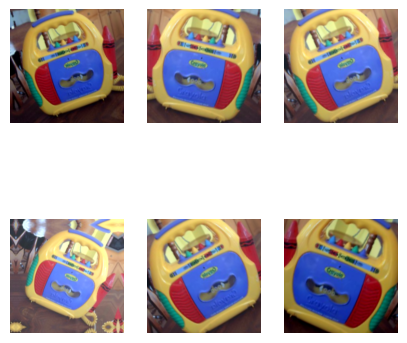

In [183]:
plt.figure(figsize=(5,5))
for images, _ in train_data.take(1):
    for i in range(6):                    
        augmented_images = data_augmentation(data_batch[20])
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(augmented_images.numpy().astype("uint8"))
        plt.axis("off")

I'll add this to the model architecture later.

#### ②rescale--to 0~1

Just like what I did in previous course--min max normalization, prevent from the phenomenon that greater values dominate lower values, help with numeric stability and faster convergence. Of course, ease to comparison is another factor too.

I'll add this to the model architecture later.

#### ③Weight Regularization

This will select major features, and make non-relevant features(eg.noises) have a small weight.

L1 or L2 are avaiable for us to choose. L2 is more commonly used in CNN, as it shrinks the weights towards zero, but still allowing small non-zero weights, whiel L1 sets some of the weights exactly to zero---L1 sparse, L2 non-sparse. L1 is more useful in cases where redundant/irrelevant features are in the data.

I'll choose L2, add this to the model architecture later.

#### ④Dropout

Some specific neurons might always depend on previous layer’s a few features which might be unseen during testing. So, this regularization forces the model to learn more robust features that are useful in conjunction with many different random subsets of other neurons, and reduces the dependence on any particular feature.

I'll add this to the model architecture later.

#### put all techniques together



In [138]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization

inputs = keras.Input(shape=(224, 224, 3), name='IN')
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(32, (3,3), activation = 'relu',kernel_regularizer=l2(0.001),name='CONV1')(x)

x = layers.MaxPool2D(2,2,name='POOL1')(x)
x = layers.Conv2D(64, (3,3) , activation = 'relu',kernel_regularizer=l2(0.001),name='CONV2')(x)

x = layers.MaxPool2D(2,2,name='POOL2')(x)
x = layers.Conv2D(128, (3,3) , activation = 'relu',kernel_regularizer=l2(0.001),name='CONV3')(x)

x = layers.MaxPool2D(2,2,name='POOL3')(x)
x = layers.Flatten(name='FLATTEN')(x)


outputs = layers.Dense(256, activation="relu",kernel_regularizer=l2(0.001))(x)
outputs = layers.Dropout(0.5)(x)
outputs = layers.Dense(128, activation="relu",kernel_regularizer=l2(0.001))(x)
outputs = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation="softmax",name='OUT')(x)

m2 = keras.Model(inputs=inputs, outputs=outputs,name='M2')
m2.summary()

Model: "M2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 IN (InputLayer)             [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_32 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 CONV1 (Conv2D)              (None, 222, 222, 32)      896       
                                                                 
 POOL1 (MaxPooling2D)        (None, 111, 111, 32)      0         
                                                                 
 CONV2 (Conv2D)              (None, 109, 109, 64)      18496     
                                                                 
 POOL2 (MaxPooling2D)        (None, 54, 54, 64)        0        

#### model compile and fit

In [ ]:
m2.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [139]:
history2 = m2.fit(
    train_data,
    epochs=30,
    validation_data=valid_data)

Epoch 1/30
296/296 [==============================] - 78s 248ms/step - loss: 1.9026 - accuracy: 0.3656 - val_loss: 1.6689 - val_accuracy: 0.4545
Epoch 2/30
296/296 [==============================] - 73s 244ms/step - loss: 1.6072 - accuracy: 0.4777 - val_loss: 1.4276 - val_accuracy: 0.5294
Epoch 3/30
296/296 [==============================] - 72s 242ms/step - loss: 1.5050 - accuracy: 0.5104 - val_loss: 1.2866 - val_accuracy: 0.5921
Epoch 4/30
296/296 [==============================] - 73s 245ms/step - loss: 1.4565 - accuracy: 0.5310 - val_loss: 1.3547 - val_accuracy: 0.5867
Epoch 5/30
296/296 [==============================] - 73s 245ms/step - loss: 1.4052 - accuracy: 0.5580 - val_loss: 1.2166 - val_accuracy: 0.6157
Epoch 6/30
296/296 [==============================] - 73s 244ms/step - loss: 1.3495 - accuracy: 0.5745 - val_loss: 1.2185 - val_accuracy: 0.6203
Epoch 7/30
296/296 [==============================] - 74s 248ms/step - loss: 1.3306 - accuracy: 0.5838 - val_loss: 1.2390 - val_ac

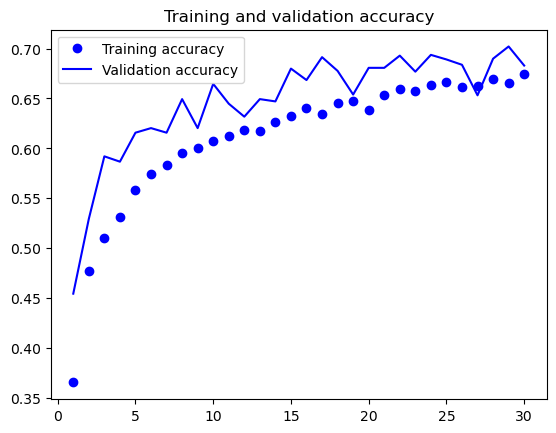

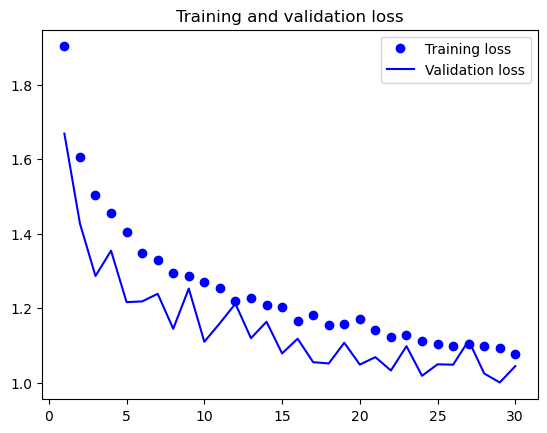

In [140]:
import matplotlib.pyplot as plt
accuracy = history2.history["accuracy"]
val_accuracy = history2.history["val_accuracy"]
loss = history2.history["loss"]
val_loss = history2.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

For valid dataset, both the accuracy and loss have the tendency I hoped. 

Both of them behave better than the train(higher/lower location).

But both lines quite fluctuate, and the accuracy scores for both valid and train are not very good. I think in the future I may have to tune hyperparameters, and more epochs.


#### prediction

In [141]:
test2_loss, test2_acc = m2.evaluate(test_data)         
print(f"after trying: {test2_acc:.3f}")

82/82 [==============================] - 6s 61ms/step - loss: 1.0875 - accuracy: 0.6885
after trying: 0.688


Based on the prediction, it just improves 10 points than last time. Still needs to be improved. 

## 4. Fine-tuning

### A. Feature extraction plus data augmentation

##### use a pre-trained model

vgg, resnet, inception, mobilenet, can all be used as pre-trained CNN models. 

This time I randomly select resnet50 to see how it performs. Maybe in the future I can change to another one, based on the specific scenarios. 

##### show the base, then freeze all layers

Here I load the pre-trained resnet first, then freeze the weights of all  layers -- I don't want the learned feature representations to be destroyed or changed, during later training.

In [94]:
from tensorflow.keras.applications.resnet50 import ResNet50
conv_base =  ResNet50(
    weights="imagenet",
    include_top=False)

conv_base.trainable = False

94765736/94765736 [==============================] - 3s 0us/step


##### add data augmentation, dropout-->model architecture

add own idea of layers

In [95]:
from tensorflow.keras.applications.resnet50 import preprocess_input

inputs = keras.Input(shape=(224,224, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(100)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation="softmax")(x)
m3 = keras.Model(inputs, outputs)
m3.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

##### model compile, data plug in

In [96]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history3 = m3.fit(
    train_data,
    epochs=30,
    validation_data=valid_data,
    callbacks=callbacks)

Epoch 1/30
296/296 [==============================] - 91s 284ms/step - loss: 15.6122 - accuracy: 0.8634 - val_loss: 3.6521 - val_accuracy: 0.9733
Epoch 2/30
296/296 [==============================] - 81s 273ms/step - loss: 9.7882 - accuracy: 0.9261 - val_loss: 2.9888 - val_accuracy: 0.9778
Epoch 3/30
296/296 [==============================] - 81s 273ms/step - loss: 8.2514 - accuracy: 0.9391 - val_loss: 3.3203 - val_accuracy: 0.9771
Epoch 4/30
296/296 [==============================] - 83s 278ms/step - loss: 7.1534 - accuracy: 0.9458 - val_loss: 1.9473 - val_accuracy: 0.9840
Epoch 5/30
296/296 [==============================] - 81s 271ms/step - loss: 6.4317 - accuracy: 0.9528 - val_loss: 2.4608 - val_accuracy: 0.9824
Epoch 6/30
296/296 [==============================] - 81s 272ms/step - loss: 5.8524 - accuracy: 0.9552 - val_loss: 2.0519 - val_accuracy: 0.9832
Epoch 7/30
296/296 [==============================] - 81s 270ms/step - loss: 5.2836 - accuracy: 0.9586 - val_loss: 3.0133 - val_a

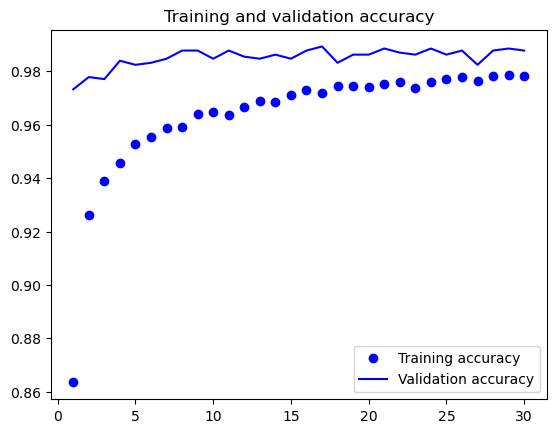

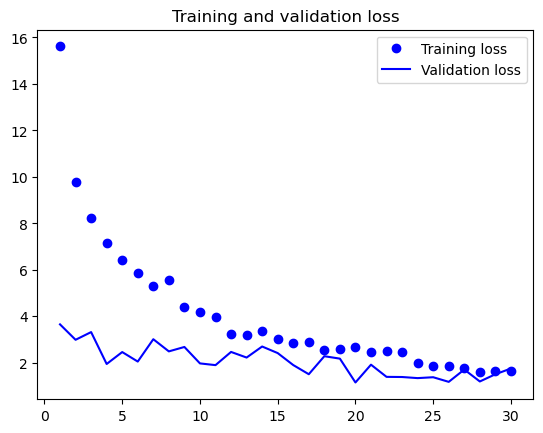

In [97]:
import matplotlib.pyplot as plt
accuracy = history3.history["accuracy"]
val_accuracy = history3.history["val_accuracy"]
loss = history3.history["loss"]
val_loss = history3.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Valid: 

For accuracy, it's almost constant, and very high; for the loss, it doesn't change much neither, and is very low as always. 
In terms of numbers, in either metrics, they behave no worse than train.

##### prediction

In [111]:
test_model1 = keras.models.load_model("feature_extraction_with_data_augmentation.keras")
test_loss_1, test_acc_1 = test_model1.evaluate(test_data)
print(f"resnet first time accuracy: {test_acc_1:.3f}")

82/82 [==============================] - 8s 68ms/step - loss: 2.8390 - accuracy: 0.9820
resnet first time accuracy: 0.982


As expected.

### B. Tune the model

##### here I randomly choose to unfreeze last six layers

Unfreezing layers will allow the model to continue learning and adapting to the task-specific features.

In [112]:
conv_base.trainable = True                 
for layer in conv_base.layers[:-6]:
    layer.trainable = False

##### new model compile, data plug in

In [113]:
m3.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history3_0 = m3.fit(
    train_data,
    epochs=30,
    validation_data=valid_data,
    callbacks=callbacks)

Epoch 1/30
296/296 [==============================] - 92s 284ms/step - loss: 3.8436 - accuracy: 0.9609 - val_loss: 1.5750 - val_accuracy: 0.9862
Epoch 2/30
296/296 [==============================] - 83s 280ms/step - loss: 3.0487 - accuracy: 0.9654 - val_loss: 1.4461 - val_accuracy: 0.9862
Epoch 3/30
296/296 [==============================] - 82s 275ms/step - loss: 2.7466 - accuracy: 0.9668 - val_loss: 1.3366 - val_accuracy: 0.9878
Epoch 4/30
296/296 [==============================] - 83s 278ms/step - loss: 2.6258 - accuracy: 0.9699 - val_loss: 1.2453 - val_accuracy: 0.9878
Epoch 5/30
296/296 [==============================] - 83s 279ms/step - loss: 2.9552 - accuracy: 0.9681 - val_loss: 1.1853 - val_accuracy: 0.9885
Epoch 6/30
296/296 [==============================] - 83s 279ms/step - loss: 2.5916 - accuracy: 0.9710 - val_loss: 1.1573 - val_accuracy: 0.9893
Epoch 7/30
296/296 [==============================] - 82s 276ms/step - loss: 2.4708 - accuracy: 0.9713 - val_loss: 1.1198 - val_ac

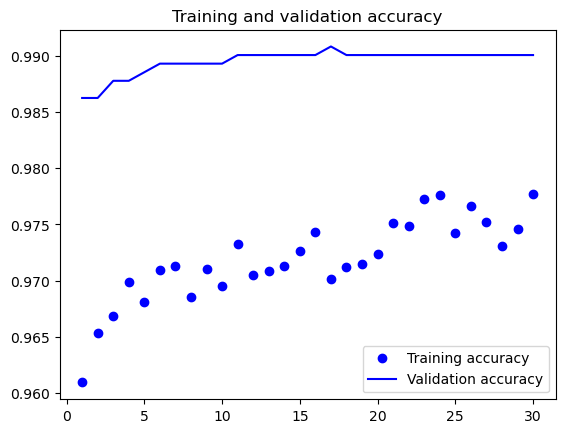

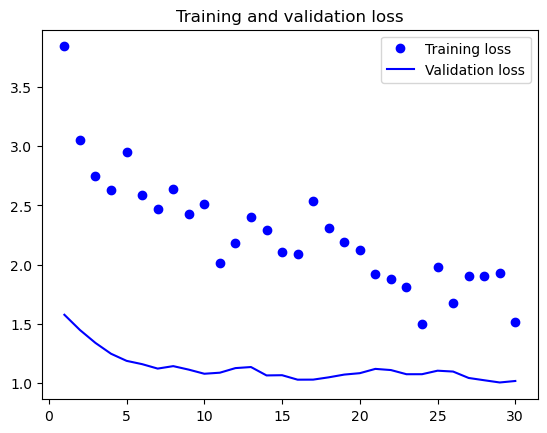

In [114]:
import matplotlib.pyplot as plt
accuracy = history3_0.history["accuracy"]
val_accuracy = history3_0.history["val_accuracy"]
loss = history3_0.history["loss"]
val_loss = history3_0.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Valid: 
for the accuracy, still doesn't change much, even in the second part it keeps constant(0.9901). Still very high; 
for the loss, it continues decreasing. 
In terms of scores, in either scenarios they behave better than train. 

##### prediction

In [115]:
test_model2 = keras.models.load_model("fine_tuning.keras")
test_loss_2, test_acc_2 = test_model2.evaluate(test_data)
print(f"fine-tuning resnet accuracy: {test_acc_2:.3f}")

82/82 [==============================] - 8s 74ms/step - loss: 1.6247 - accuracy: 0.9878
fine-tuning resnet accuracy: 0.988


a little bit better than the one before fine-tuning.

## 5. Fine-tuning Vision Transformer(ViT)



I learned transfomer already and used one blog to do hands-on exercise, undertstanding what its architecture looks like, what single attention is, as well as multi-head attention, cross attention, finally the whole traffic. It's significantly used in NLP. 

But for image classication, since they're not single-dimensional texts, processing multi-dimension images can make computations complex; Also, because images have noises/different sizes, it will be strict in feature extraction.

Here comes ViT, a popular transformer-based model.  
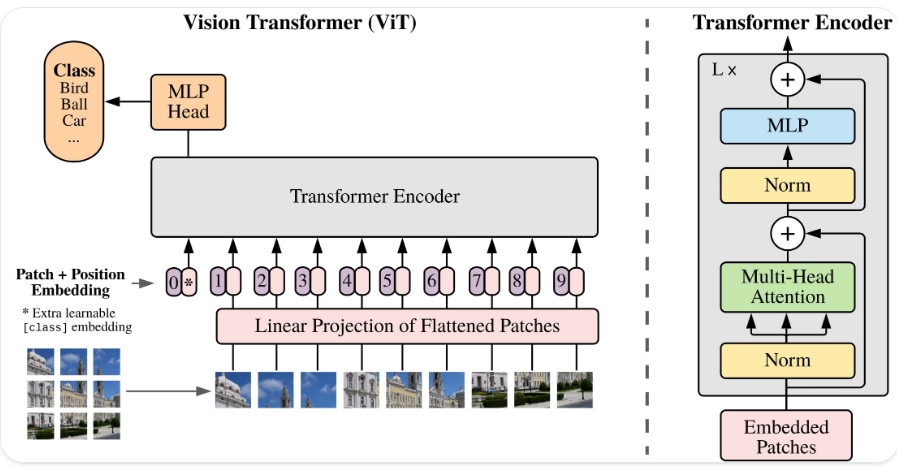

picture from huggingface: https://huggingface.co/docs/transformers/model_doc/vit



The input image is first divided into small patches, treated as tokens. Each patch is then flattened into a vector and passed through self-attention layers and FF layers(similar to origin transformer). The output of the final layer will be used to predict the class. 

In [30]:
pip install vit-keras

  Preparing metadata (setup.py) ... done
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19581 sha256=7a3f8d7c642145a150386e9d17ec4e8ddf21acda8b88f9028568a9202ef8fcc4
  Stored in directory: /root/.cache/pip/wheels/3d/7c/f1/f87f51d07a2513aa0fb128d5eb504da1fcef9c87475d9eef64
Successfully built validators
Note: you may need to restart the kernel to use updated packages.


In [32]:
pip install tensorflow_addons

Note: you may need to restart the kernel to use updated packages.


In [33]:
import tensorflow_addons as tfa

In [34]:
from vit_keras import vit

### A. Prepare the data

##### Preprocess

Specify the image size, batch size.

Still use previous data augmentation method, but utilizing a different function therefore conversions are needed. 

Rescale is as before too.

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

datagen = ImageDataGenerator(rescale=1./255, rotation_range=180 * 0.1 / np.pi,brightness_range=[max(0, 1 - 0.2), 1 + 0.2], zoom_range = [1 - 0.4, 1 + 0.4],horizontal_flip=True)
train_generator= datagen.flow_from_directory(
    train_dataset_path, target_size=(224, 224), batch_size=32, class_mode='categorical')
valid_generator = datagen.flow_from_directory(
    validation_dataset_path, target_size=(224, 224), batch_size=32, class_mode='categorical')
test_generator = datagen.flow_from_directory(
    test_dataset_path, target_size=(224, 224), batch_size=32, class_mode='categorical')

Found 9469 images belonging to 10 classes.
Found 1309 images belonging to 10 classes.
Found 2616 images belonging to 10 classes.


The result is same as before.

##### image preview

All above XX_generators are actually directory iterators, used for iterating over images in a directory. 

Goes up to the third index to find an image.

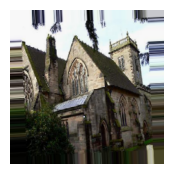

In [29]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(2, 2))
plt.imshow(train_generator[0][0][0])
plt.axis('off')
plt.show()

No problem with the data preprocessing and image loading.

### B. Build the model

##### ViT_B32 Model

vit_b16, vit_l16, vit_h14, vit_b32, are all common pre-trained VIT models. I randomly choose vit_b32. 

In [38]:
vit_model = vit.vit_b32(
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,      #can only use pretrained_top with include_top together, as an error message prompted
        classes = 10)

##### Fine-tuning on the model

Besides existing layers in the vit model, I add other layers, including the flatten, batch normalization(prevent overfitting), fully connected layers.

Here, in the fully connected layer, since I're using vit(which needs tensorflow_addons to be installed), I're going to use its own activation functions. Among them, for image classification use, ***tfa.activations.gelu, tfa.activations.mish, tfa.activations.softplus, tfa.activations.swish*** are common ones. I choose the first one.

Still assign the model name to make it clear.

In [39]:
vit = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(40, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(10, 'softmax')
    ],
    name = 'VIT')

vit.summary()

Model: "VIT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 40)                30760     
                                                                 
 batch_normalization_1 (Batc  (None, 40)               160       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 10)                410     

### C. Train the model

##### compile

I use tfa's own optimizer too, like above. ***tfa.optimizers.AdamW, tfa.optimizers.LAMB, tfa.optimizers.SGDW, tfa.optimizers.RectifiedAdam*** are common ones for this task. I choose the last one.  

Just like what I do in fine-tuning resnet, I also add lr to optimizer. 

In [41]:
vit.compile(optimizer = tfa.optimizers.RectifiedAdam(learning_rate = 1e-5),
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

##### fit

Early stopping means stops training when the performance on the valid dataset starts to degrade. For this reason, I don't want the early stopping to happen too early, otherwise, it may mean that the model fails to learn and generalize well on the data.

reduce_lr monitors a specified metric, then reduces the learning rate if the metric does not improve after a specified number of epochs.





In [43]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                  factor=0.2,
                                                  patience=5, 
                                                  min_lr=0.0001)


vit.fit(x = train_generator,validation_data = valid_generator,epochs = 30,callbacks = [earlystopping,reduce_lr])

Epoch 1/30
296/296 [==============================] - 184s 620ms/step - loss: 0.2159 - accuracy: 0.9617 - val_loss: 0.1342 - val_accuracy: 0.9733 - lr: 1.0000e-05
Epoch 2/30
296/296 [==============================] - 183s 619ms/step - loss: 0.1678 - accuracy: 0.9710 - val_loss: 0.1019 - val_accuracy: 0.9801 - lr: 1.0000e-05
Epoch 3/30
296/296 [==============================] - 182s 614ms/step - loss: 0.1379 - accuracy: 0.9760 - val_loss: 0.0766 - val_accuracy: 0.9862 - lr: 1.0000e-05
Epoch 4/30
296/296 [==============================] - 183s 618ms/step - loss: 0.1257 - accuracy: 0.9773 - val_loss: 0.0904 - val_accuracy: 0.9809 - lr: 1.0000e-05
Epoch 5/30
296/296 [==============================] - 182s 614ms/step - loss: 0.1059 - accuracy: 0.9798 - val_loss: 0.0743 - val_accuracy: 0.9870 - lr: 1.0000e-05
Epoch 6/30
296/296 [==============================] - 181s 612ms/step - loss: 0.0917 - accuracy: 0.9835 - val_loss: 0.0662 - val_accuracy: 0.9870 - lr: 1.0000e-05
Epoch 7/30
296/296 [==

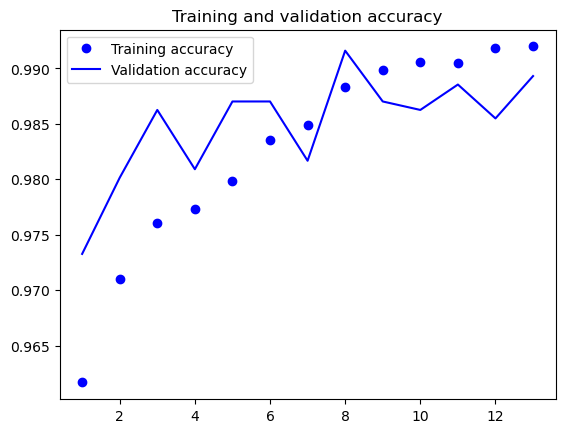

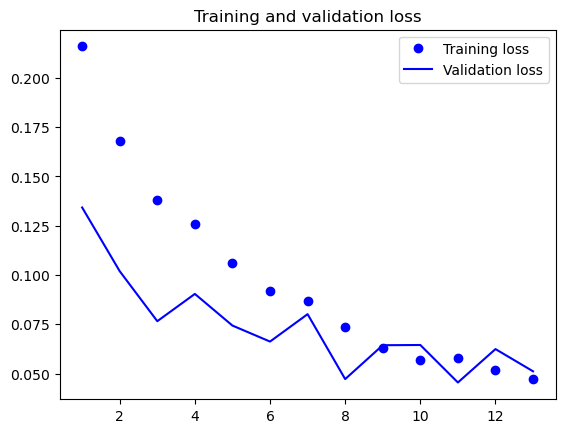

In [44]:
history_vit = vit.history

import matplotlib.pyplot as plt
accuracy = history_vit.history["accuracy"]
val_accuracy = history_vit.history["val_accuracy"]
loss = history_vit.history["loss"]
val_loss = history_vit.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Just as before, since I did early stopping, not using all epoches,

even the tiny change of metric values will be augmented significantly like above. 

But overall the tendencies are as expected, and behave no worse than the train.

About the fluctuation, I think hyperparameter tuning is needed.

In [47]:
vit_loss, vit_acc = vit.evaluate(test_generator)         
print(f"vit: {vit_acc:.3f}")

82/82 [==============================] - 41s 504ms/step - loss: 0.0821 - accuracy: 0.9805
vit: 0.981


# Summary





The initial accuracy of CNN is 61.9%, and after some works it becomes 68.8%. Though not improving much, the overall tendency is what I want, and the performance is not bad compared with the train's. I may need more epoches and hyperparameter tuning. Then comes pre-trained model. I have 98.2% and 98.8% before and after fine-tuning. Finally Vision Transfromer model. I directly add components to it then fit, and got 98.1%. Pre-trained models even after my fine-tuning still work fine. When I do the own model I have to study more about what to put into the model.